In [171]:
import pandas as pd
import matplotlib.pyplot as plt

In [172]:
df = pd.read_json('/scratch1/redditqa/data/ask_historians/AskHistorians.jsonl', lines=True, orient='records')
#df = pd.read_json('C:\\Users\\Marc Ulrich\\Downloads\\torrent\\reddit\\subreddits\\AskHistorians.jsonl', lines=True, orient='records')

In [173]:
df.head()

,question_created_utc,question_retrieved_on,question_deleted,question_title,question_selftext,question_score,question_char_length,question_selftext_char_length,answers
0,1672513331000,1673167877000,False,Native American Book Recommendations?,Hi! I'm on the hunt for more book recommendati...,38,37,1175,"[{'answer_id': 'j2fdktj', 'answer_created_utc'..."
1,1347846326000,1413569904000,False,"What counted as ""science"" in the Greek Academy...",,6,60,0,"[{'answer_id': 'c6998pv', 'answer_created_utc'..."
2,1672513458000,1673167876000,False,What is the most visually accurate depiction o...,,1,54,0,"[{'answer_id': 'j2etbdl', 'answer_created_utc'..."
3,1347846624000,1413569895000,False,There is a scene in the movie 'Gladiator' whic...,I'm aware the film is far from historically ac...,37,192,157,"[{'answer_id': 'c69eal6', 'answer_created_utc'..."
4,1672517086000,1673167832000,False,Were Roman curse tablets mass produced? If so ...,I saw a meme saying there was evidence that Ro...,9,50,227,"[{'answer_id': 'j2fbm7v', 'answer_created_utc'..."


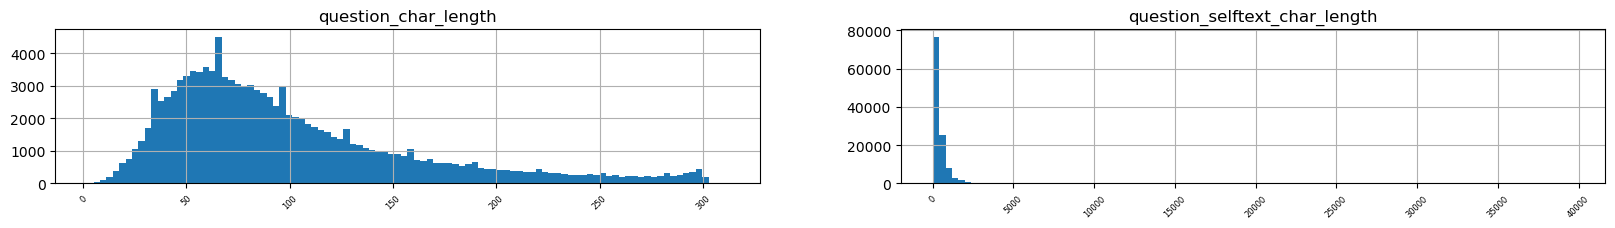

In [174]:
figsize=(20, 2)
fig, axes = plt.subplots(nrows=1, ncols=2)

for i, colname in enumerate(['question_char_length', 'question_selftext_char_length']):
    axes[i].set_title(colname)
    df[colname].hist(ax=axes[i], bins=100, xrot=45, figsize=figsize, xlabelsize=6)

In [175]:
# Unnest the answers
df_unnested = df.explode('answers')
df_unnested = pd.concat([
    df_unnested['answers'].apply(pd.Series),
    df_unnested.drop(columns=['answers'])], axis=1)
df_unnested.head()

,answer_id,answer_created_utc,answer_retrieved_on,answer_deleted,answer_body,answer_score,answer_char_length,question_created_utc,question_retrieved_on,question_deleted,question_title,question_selftext,question_score,question_char_length,question_selftext_char_length
0,j2fdktj,1672522188000,1673022200000,False,I'm going to recommend some of my favorites be...,7,3014,1672513331000,1673167877000,False,Native American Book Recommendations?,Hi! I'm on the hunt for more book recommendati...,38,37,1175
0,j2et07l,1672513332000,1673022760000,False,Welcome to /r/AskHistorians. **Please [Read Ou...,1,1774,1672513331000,1673167877000,False,Native American Book Recommendations?,Hi! I'm on the hunt for more book recommendati...,38,37,1175
1,c6998pv,1347854573000,1429917825000,False,Greek science can be better described as natur...,3,675,1347846326000,1413569904000,False,"What counted as ""science"" in the Greek Academy...",,6,60,0
1,c699oqe,1347856387000,1429918037000,False,"Firstly, it's AD 500. Pet peeve.\n\nSecondly,...",3,586,1347846326000,1413569904000,False,"What counted as ""science"" in the Greek Academy...",,6,60,0
1,c69px53,1347936114000,1429925821000,False,"Would like to answer, but first I wanted to as...",1,216,1347846326000,1413569904000,False,"What counted as ""science"" in the Greek Academy...",,6,60,0


In [176]:
# Extract unique question_created_utc values
# unique_question_utc = df['question_created_utc'].unique()

# Filter out unwanted answers based on conditions
filtered_df = df[df['answers'].apply(lambda answers: all(
    not answer.get('answer_deleted', False) and not answer.get('answer_body', '').startswith("Welcome to /r/AskHistorians")
    for answer in answers
))].copy()  # Use .copy() to create a copy of the DataFrame

# Sort answers within each question by answer_score in descending order
filtered_df['answers'] = filtered_df['answers'].apply(lambda answers: sorted(answers, key=lambda x: x.get('answer_score', 0), reverse=True))

# Calculate the average answer_score/question_score for the top 1, top 2, and top 3 answers
avg_top_1 = filtered_df.apply(lambda row: row['answers'][0].get('answer_score', 0) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()
avg_top_2 = filtered_df.apply(lambda row: sum(answer.get('answer_score', 0) for answer in row['answers'][:2]) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()
avg_top_3 = filtered_df.apply(lambda row: sum(answer.get('answer_score', 0) for answer in row['answers'][:3]) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()

avg_best_1 = filtered_df.apply(lambda row: row['answers'][0].get('answer_score', 0) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()
avg_best_2 = filtered_df.apply(lambda row: sum(answer.get('answer_score', 0) for answer in row['answers'][1:2]) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()
avg_best_3 = filtered_df.apply(lambda row: sum(answer.get('answer_score', 0) for answer in row['answers'][2:3]) / max(row['question_score'], 1) if row['answers'] else 0, axis=1).mean()

print(f"\nOverall Average Answer Score/Question Score for Top 1 Answers: {avg_top_1}")
print(f"Overall Average Answer Score/Question Score for Top 2 Answers: {avg_top_2}")
print(f"Overall Average Answer Score/Question Score for Top 3 Answers: {avg_top_3}")

print(f"\nOverall Average Answer Score/Question Score for Best Answer: {avg_best_1}")
print(f"Overall Average Answer Score/Question Score for 2nd Best Answer: {avg_best_2}")
print(f"Overall Average Answer Score/Question Score for 3rd Best Answer: {avg_best_3}")


Overall Average Answer Score/Question Score for Top 1 Answers: 1.108641226151884
Overall Average Answer Score/Question Score for Top 2 Answers: 1.611124099737469
Overall Average Answer Score/Question Score for Top 3 Answers: 1.7520198772967157

Overall Average Answer Score/Question Score for Best Answer: 1.108641226151884
Overall Average Answer Score/Question Score for 2nd Best Answer: 0.5024828735855852
Overall Average Answer Score/Question Score for 3rd Best Answer: 0.14089577755924657


In [177]:
avg_answers_count = filtered_df['answers'].apply(len).mean()
print(f"Average Count of Answers: {avg_answers_count}")

Average Count of Answers: 4.012783173842556


In [178]:
avg_question_score = filtered_df['question_score'].mean()
print(f"Average Question Score: {avg_question_score}")

Average Question Score: 132.12512015609533


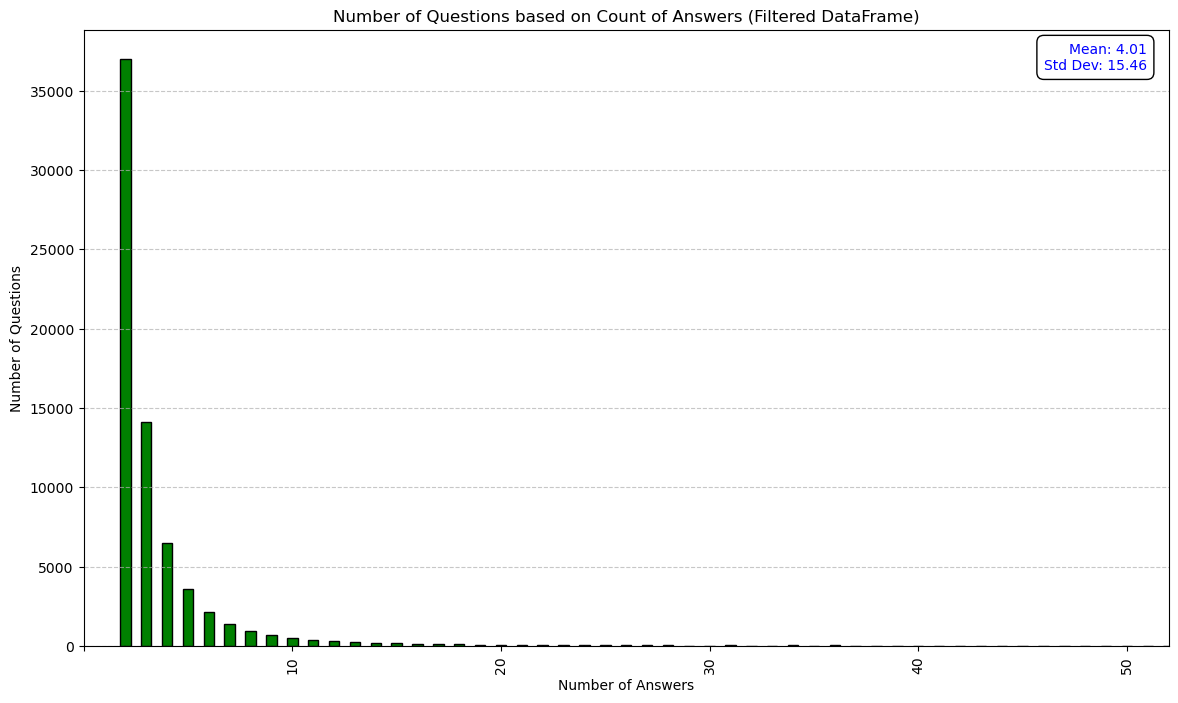

In [179]:
# Count the number of answers for each question in the filtered DataFrame
filtered_df['num_answers'] = filtered_df['answers'].apply(lambda answers: len(answers) if isinstance(answers, list) else 0)

# Use .loc to avoid SettingWithCopyWarning
filtered_df = filtered_df.copy()

# Count the occurrences of each unique number of answers
questions_count = filtered_df['num_answers'].value_counts()

# Plot the histogram
plt.figure(figsize=(14, 8))
questions_count.sort_index().plot(kind='bar', color='green', edgecolor='black')
plt.title('Number of Questions based on Count of Answers (Filtered DataFrame)')
plt.xlabel('Number of Answers')
plt.ylabel('Number of Questions')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis range from 0 to 50
plt.xlim(0, 50)

# Set x-axis ticks at intervals of 10
plt.xticks(range(-2, 50, 10))

# Add mean and standard deviation with a non-transparent box
mean_answers = filtered_df['num_answers'].mean()
std_dev_answers = filtered_df['num_answers'].std()
box_text = f'Mean: {mean_answers:.2f}\nStd Dev: {std_dev_answers:.2f}'
plt.text(0.98, 0.98, box_text, transform=plt.gca().transAxes, color='blue', ha='right', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', boxstyle='round,pad=0.5'))


# Save the plot as a PNG file
plt.savefig('eda_askhistorians_output/questions_count_histogram_filtered.png')

plt.show()

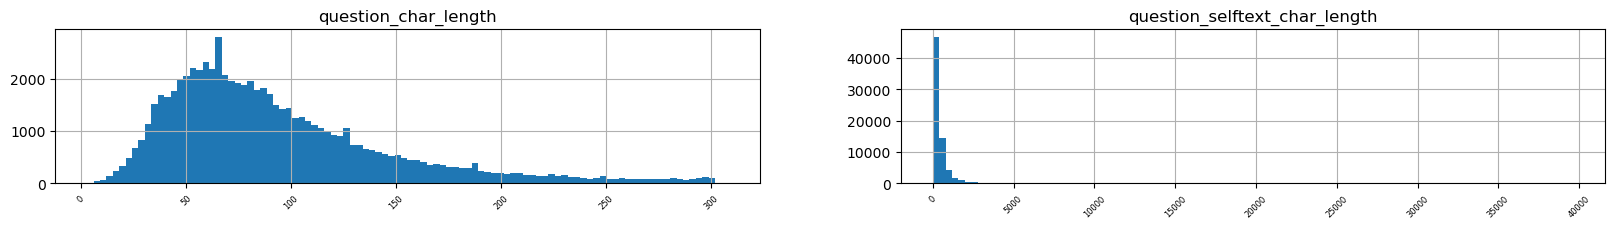

In [180]:
figsize=(20, 2)
fig, axes = plt.subplots(nrows=1, ncols=2)

for i, colname in enumerate(['question_char_length', 'question_selftext_char_length']):
    axes[i].set_title(colname)
    filtered_df[colname].hist(ax=axes[i], bins=100, xrot=45, figsize=figsize, xlabelsize=6)
plt.savefig('eda_askhistorians_output/char_histograms.png')    

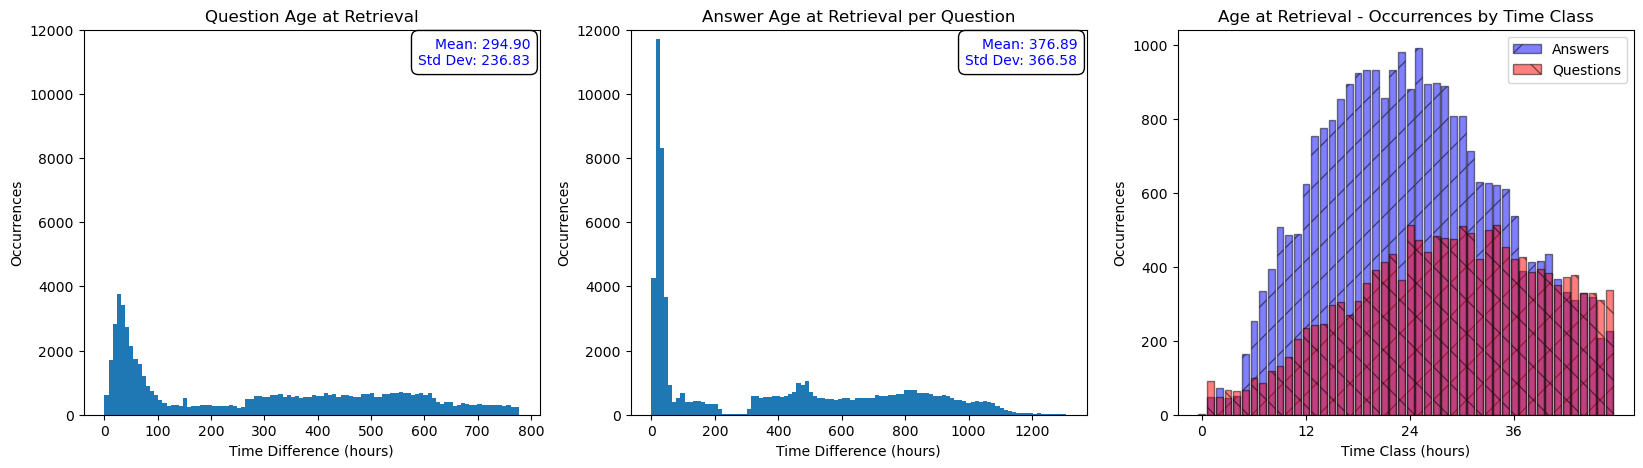

In [181]:
# Define time classes (e.g., 12 hours, 24 hours)
time_classes = [x for x in range(48)]

# Convert 'created_utc' and 'retrieved_on' columns to datetime objects
filtered_df['question_created_utc'] = pd.to_datetime(filtered_df['question_created_utc'], unit='ms')
filtered_df['question_retrieved_on'] = pd.to_datetime(filtered_df['question_retrieved_on'], unit='ms')

# Calculate time differences for questions
filtered_df['question_time_difference'] = ((filtered_df['question_retrieved_on'] - filtered_df['question_created_utc']).dt.total_seconds()) / (3600 * 24)  # in days

# Check if 'answers' exists and is not empty
if 'answers' in filtered_df.columns and not filtered_df['answers'].empty:
    # Iterate over each row in the DataFrame
    for i, row in filtered_df.iterrows():
        # Initialize an empty list to store answer time differences
        answer_time_differences = []

        # Check if 'answers' is not NaN
        if isinstance(row['answers'], list) and pd.notna(row['answers'][0]):
            # Iterate over each answer for the current row
            for answer in row['answers']:
                # Check if 'answer_created_utc' exists within the answer item
                if 'answer_created_utc' in answer:
                    # Convert 'answer_created_utc' and 'answer_retrieved_on' to datetime objects
                    answer_created_utc = pd.to_datetime(answer.get('answer_created_utc'), unit='ms')
                    answer_retrieved_on = pd.to_datetime(answer.get('answer_retrieved_on'), unit='ms')

                    # Calculate time difference for the current answer and append to the list
                    time_difference_seconds = (answer_retrieved_on - answer_created_utc).total_seconds()
                    answer_time_difference = time_difference_seconds / (3600 * 24)  # in days
                    answer_time_differences.append(answer_time_difference)

            # Set the 'answer_time_difference' for the current row as the average of all answer time differences
            if answer_time_differences:
                filtered_df.at[i, 'answer_time_difference'] = sum(answer_time_differences) / len(answer_time_differences)

# Create a bar plot for time class occurrences
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Plot for question time differences
question_time_diff_column = 'question_time_difference'
question_time_diff_values = filtered_df[question_time_diff_column].dropna()
question_time_diff_values = question_time_diff_values[question_time_diff_values > 0]  # Consider only positive values
axes[0].set_title('Question Age at Retrieval')
axes[0].hist(question_time_diff_values, bins=100)
axes[0].set_xlabel('Time Difference (hours)')
axes[0].set_ylabel('Occurrences')
axes[0].set_ylim(0, 12000)  # Set y-axis limit to 12000 occurrences

# Add mean and standard deviation with a non-transparent box (top-right corner)
mean_question_time_diff = question_time_diff_values.mean()
std_dev_question_time_diff = question_time_diff_values.std()
box_text_question_time_diff = f'Mean: {mean_question_time_diff:.2f}\nStd Dev: {std_dev_question_time_diff:.2f}'
axes[0].text(0.98, 0.98, box_text_question_time_diff, transform=axes[0].transAxes, color='blue', ha='right', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', boxstyle='round,pad=0.5'))

# Plot for answer time differences
answer_time_diff_column = 'answer_time_difference'
answer_time_diff_values = filtered_df[answer_time_diff_column].dropna()
answer_time_diff_values = answer_time_diff_values[answer_time_diff_values > 0]  # Consider only positive values
axes[1].set_title('Answer Age at Retrieval per Question')
axes[1].hist(answer_time_diff_values, bins=100)
axes[1].set_xlabel('Time Difference (hours)')
axes[1].set_ylabel('Occurrences')
axes[1].set_ylim(0, 12000)  # Set y-axis limit to 12000 occurrences

# Add mean and standard deviation with a non-transparent box (top-right corner)
mean_answer_time_diff = answer_time_diff_values.mean()
std_dev_answer_time_diff = answer_time_diff_values.std()
box_text_answer_time_diff = f'Mean: {mean_answer_time_diff:.2f}\nStd Dev: {std_dev_answer_time_diff:.2f}'
axes[1].text(0.98, 0.98, box_text_answer_time_diff, transform=axes[1].transAxes, color='blue', ha='right', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', boxstyle='round,pad=0.5'))

# Plot for answer time class occurrences
time_class_counts = pd.cut(filtered_df[answer_time_diff_column], bins=[-1] + time_classes, labels=time_classes)
question_time_class_counts = pd.cut(filtered_df[question_time_diff_column], bins=[-1] + time_classes, labels=time_classes)

# Bar plot for answers
axes[2].bar(time_classes, time_class_counts.value_counts(sort=False), color='blue', edgecolor='black', alpha=0.5, hatch='/', label='Answers')

# Bar plot for questions
axes[2].bar(time_classes, question_time_class_counts.value_counts(sort=False), color='red', edgecolor='black', alpha=0.5, hatch='\\', label='Questions')

axes[2].set_title('Age at Retrieval - Occurrences by Time Class')
axes[2].set_xlabel('Time Class (hours)')
axes[2].set_ylabel('Occurrences')
axes[2].legend()

# Additional settings for better visibility
divisible_by_12_labels = [tc for tc in time_classes if tc % 12 == 0]  # Only include labels for time classes divisible by 12
axes[2].set_xticks(divisible_by_12_labels)
axes[2].set_xticklabels(divisible_by_12_labels)

plt.savefig('eda_askhistorians_output/time_class_occurrences.png')  # Save the plot as PNG
plt.show()

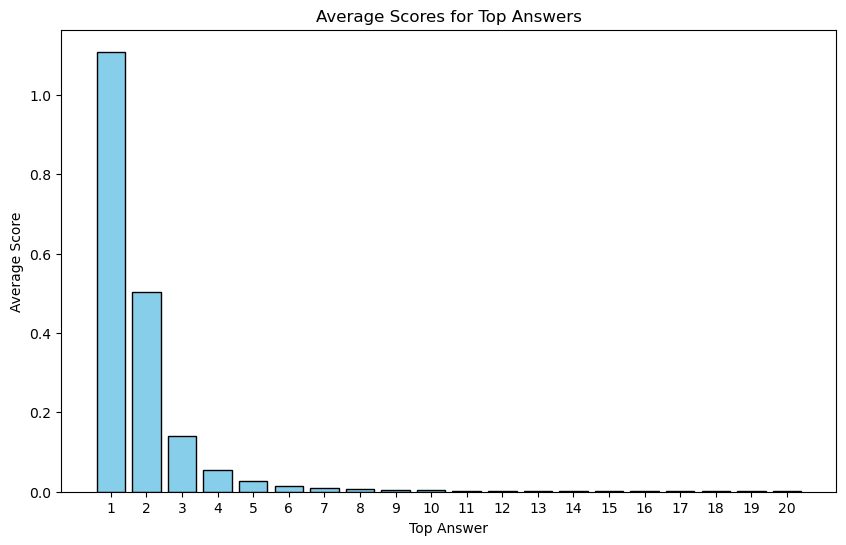

In [182]:
# Calculate average scores for each top answer
avg_scores = []
max_top_answers = 20

for x in range(1, max_top_answers + 1):
    avg_best_x = filtered_df.apply(
        lambda row: sum(answer.get('answer_score', 0) for answer in row['answers'][x-1:x]) / max(row['question_score'], 1) if row['answers'] else 0,
        axis=1
    )
    avg_scores.append(avg_best_x.mean())

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(range(1, max_top_answers + 1), avg_scores, color='skyblue', edgecolor='black')
plt.title('Average Scores for Top Answers')
plt.xlabel('Top Answer')
plt.ylabel('Average Score')
plt.xticks(range(1, max_top_answers + 1))
plt.savefig('eda_askhistorians_output/average_scores_top_answers.png')  # Save the plot as PNG
plt.show()

In [183]:
# Count the number of answers for each question in the filtered DataFrame
filtered_df['num_answers'] = filtered_df['answers'].apply(lambda answers: len(answers) if isinstance(answers, list) else 0)

# Define the list of quantiles to calculate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Calculate quantiles for the number of max answers
quantile_values = filtered_df['num_answers'].quantile(quantiles)

# Create a table with quantile values
quantile_table = pd.DataFrame({
    'Quantile Value': quantiles,
    'Threshold for Num Answers': quantile_values
})

# Display the table
print(quantile_table)

# Save the table as a CSV file
quantile_table.to_csv('eda_askhistorians_output/quantile_table.csv', index=False)

      Quantile Value  Threshold for Num Answers
0.10            0.10                        2.0
0.25            0.25                        2.0
0.50            0.50                        2.0
0.75            0.75                        4.0
0.90            0.90                        6.0


In [184]:
# Define the list of quantiles to calculate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Calculate quantiles for question_char_length
question_char_length_quantiles = filtered_df['question_char_length'].quantile(quantiles)

# Create a table with quantile values for question_char_length
question_char_length_quantile_table = pd.DataFrame({
    'Quantile Value': quantiles,
    'Threshold for Question Char Length': question_char_length_quantiles
})

# Display the table for question_char_length
print("Quantile Table for Question Char Length:")
print(question_char_length_quantile_table)
print()

# Calculate quantiles for question_selftext_char_length
question_selftext_char_length_quantiles = filtered_df['question_selftext_char_length'].quantile(quantiles)

# Create a table with quantile values for question_selftext_char_length
question_selftext_char_length_quantile_table = pd.DataFrame({
    'Quantile Value': quantiles,
    'Threshold for Question Selftext Char Length': question_selftext_char_length_quantiles
})

# Display the table for question_selftext_char_length
print("Quantile Table for Question Selftext Char Length:")
print(question_selftext_char_length_quantile_table)
print()

# Save the tables as CSV files
question_char_length_quantile_table.to_csv('eda_askhistorians_output/question_char_length_quantile_table.csv', index=False)
question_selftext_char_length_quantile_table.to_csv('eda_askhistorians_output/question_selftext_char_length_quantile_table.csv', index=False)


Quantile Table for Question Char Length:
      Quantile Value  Threshold for Question Char Length
0.10            0.10                                39.0
0.25            0.25                                55.0
0.50            0.50                                81.0
0.75            0.75                               117.0
0.90            0.90                               168.0

Quantile Table for Question Selftext Char Length:
      Quantile Value  Threshold for Question Selftext Char Length
0.10            0.10                                          0.0
0.25            0.25                                          4.0
0.50            0.50                                        239.0
0.75            0.75                                        507.0
0.90            0.90                                        883.0


In [185]:
# Calculate quantiles for question_time_difference
question_time_diff_quantiles = filtered_df['question_time_difference'].quantile(quantiles)

# Create a table with quantile values for question_time_difference
question_time_diff_quantile_table = pd.DataFrame({
    'Quantile Value': quantiles,
    'Threshold for Question Time Difference': question_time_diff_quantiles
})

# Display the table for question_time_difference
print("Quantile Table for Question Time Difference:")
print(question_time_diff_quantile_table)
print()

# Calculate quantiles for answer_time_difference
answer_time_diff_quantiles = filtered_df['answer_time_difference'].quantile(quantiles)

# Create a table with quantile values for answer_time_difference
answer_time_diff_quantile_table = pd.DataFrame({
    'Quantile Value': quantiles,
    'Threshold for Answer Time Difference': answer_time_diff_quantiles
})

# Display the table for answer_time_difference
print("Quantile Table for Answer Time Difference:")
print(answer_time_diff_quantile_table)
print()

# Calculate average scores for top answers
avg_best_quantiles = []

# Save the tables as CSV files
question_time_diff_quantile_table.to_csv('eda_askhistorians_output/question_time_diff_quantile_table.csv', index=False)
answer_time_diff_quantile_table.to_csv('eda_askhistorians_output/answer_time_diff_quantile_table.csv', index=False)

Quantile Table for Question Time Difference:
      Quantile Value  Threshold for Question Time Difference
0.10            0.10                               12.659676
0.25            0.25                               38.034433
0.50            0.50                              239.547106
0.75            0.75                              486.883958
0.90            0.90                              612.450093

Quantile Table for Answer Time Difference:
      Quantile Value  Threshold for Answer Time Difference
0.10            0.10                             16.007025
0.25            0.25                             27.384988
0.50            0.50                            324.872854
0.75            0.75                            709.296600
0.90            0.90                            917.008282
